>
> # MaaSSim tutorial
>
> ## Results
>
-----

Run the Exec simulation with 'config.json' parameterisation and parse the results


import simulator

In [3]:
import os, sys
import pandas as pd
import logging
from dotmap import DotMap
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate, simulate_parallel
from MaaSSim.traveller import travellerEvent
from MaaSSim.driver import driverEvent

In [5]:
params = get_config('../../data/config/default.json')  # load configuration

## simulation

In [6]:
params.simTime = 2 # 1 hour of simulation
params.nP = 50 # reuqests (and passengers)
params.nV = 30 # vehicles

In [7]:
sim = simulate(params = params, logger_level = logging.WARNING)

09-10-20 12:02:52-WARNING-Setting up 2h simulation at 2020-10-09 11:04:54 for 30 vehicles and 50 passengers in Nootdorp, Netherlands
09-10-20 12:02:54-WARNING-simulation time 1.7 s
09-10-20 12:02:54-WARNING-assertion tests for simulation results - passed


In [8]:
(sim.res[0].pax_kpi['MEETS_DRIVER_AT_PICKUP']-sim.res[0].pax_kpi['MEETS_DRIVER_AT_PICKUP'])

,ACCEPTS_OFFER,ARRIVES_AT_DROPOFF,ARRIVES_AT_PICKUP,DEPARTS_FROM_PICKUP,MEETS_DRIVER_AT_PICKUP,REQUESTS_RIDE,SETS_OFF_FOR_DEST,STARTS_DAY,RECEIVES_OFFER,IS_REJECTED_BY_VEHICLE,REJECTS_OFFER,ARRIVES_AT_DEST,PREFERS_OTHER_SERVICE,LOSES_PATIENCE,nP
sum,750.0,6620.000000,1000.0,1500.0,1034.000000,167136.000000,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50
mean,15.0,132.400000,20.0,30.0,36.928571,3410.938776,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50
std,0.0,73.062735,0.0,0.0,47.262802,2207.377992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50


## results

In [6]:
trip_id  = 3 # we inspext traveller 3
req = sim.inData.requests[sim.inData.requests.pax_id==trip_id].squeeze() # this is his ride request
aggr = sim.res[0].pax_exp.loc[trip_id] # this is his aggregated results 
raw = sim.runs[0].trips[sim.runs[0].trips.pax == trip_id]  # this is his record within simulation

In [7]:
req.to_frame().T

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,dist,ride_id,position,sim_schedule
3,3,44978600,45000745,2020-10-07 14:06:18,NaN,00:02:03,2020-10-07 14:08:21,NaN,False,NaN,1233,3,0,node time req_id od 0 NaN...


/Users/rkucharski/Documents/GitHub/MaaSSim/MaaSSim/visualizations.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status_num'] = df.apply(lambda x: travellerEvent[x.event].value, axis=1)


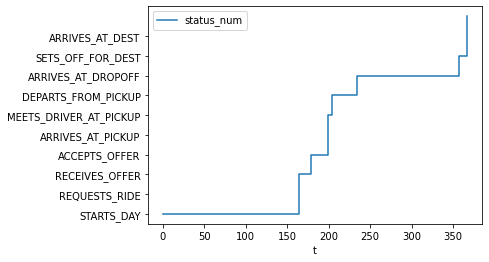

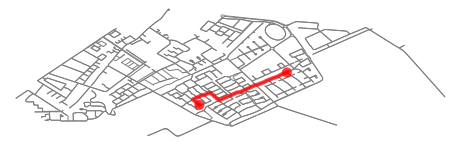

In [8]:
sim.plot_trip(trip_id)

In [9]:
print('request time:')
print(req.treq)
print('simulated request time:')
print(sim.t0+pd.to_timedelta(raw[raw.event == travellerEvent.REQUESTS_RIDE.name].squeeze().t,'s'))

request time:
2020-10-07 14:06:18
simulated request time:
2020-10-07 14:06:18


In [10]:
print('travel time at request level:')
print(req.ttrav) 
print('simulated travel time:')
print(pd.to_timedelta(raw[raw.event == travellerEvent.ARRIVES_AT_DROPOFF.name].squeeze().t -  raw[raw.event == travellerEvent.DEPARTS_FROM_PICKUP.name].squeeze().t,'s'))
print('delay:')
print(pd.to_timedelta(raw[raw.event == travellerEvent.ARRIVES_AT_DROPOFF.name].squeeze().t -  raw[raw.event == travellerEvent.DEPARTS_FROM_PICKUP.name].squeeze().t,'s')-req.ttrav)

travel time at request level:
0 days 00:02:03
simulated travel time:
0 days 00:02:03
delay:
0 days 00:00:00


In [11]:
print('lost time before')
pd.to_timedelta(raw[raw.event == travellerEvent.DEPARTS_FROM_PICKUP.name].squeeze().t -  raw[raw.event == travellerEvent.REQUESTS_RIDE.name].squeeze().t,'s')

lost time before


Timedelta('0 days 00:01:10')

In [12]:
print('lost time after')
pd.to_timedelta(raw[raw.event == travellerEvent.ARRIVES_AT_DEST.name].squeeze().t -  raw[raw.event == travellerEvent.ARRIVES_AT_DROPOFF.name].squeeze().t,'s')

lost time after


Timedelta('0 days 00:00:10')

In [13]:
print('total time since request')
pd.to_timedelta(raw[raw.event == travellerEvent.ARRIVES_AT_DEST.name].squeeze().t -  raw[raw.event == travellerEvent.REQUESTS_RIDE.name].squeeze().t,'s')

total time since request


Timedelta('0 days 00:03:23')

In [14]:
raw['duration'] = raw.t.diff().apply(lambda x: pd.to_timedelta(x,'s'))
raw

/Users/rkucharski/anaconda3/envs/maassim/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,pax,pos,t,event,veh_id,duration
0,3,44978600,0,STARTS_DAY,NaN,NaT
1,3,44978600,164,REQUESTS_RIDE,NaN,00:02:44
2,3,44978600,164,RECEIVES_OFFER,NaN,00:00:00
3,3,44978600,179,ACCEPTS_OFFER,NaN,00:00:15
4,3,44978600,199,ARRIVES_AT_PICKUP,8.0,00:00:20
5,3,44978600,204,MEETS_DRIVER_AT_PICKUP,8.0,00:00:05
6,3,44978600,234,DEPARTS_FROM_PICKUP,8.0,00:00:30
7,3,45000745,357,ARRIVES_AT_DROPOFF,8.0,00:02:03
8,3,45000745,367,SETS_OFF_FOR_DEST,NaN,00:00:10
9,3,45000745,367,ARRIVES_AT_DEST,NaN,00:00:00


# Interpretation of _aggr_


In [15]:
params.times

DotMap(request=15, transaction=20, pickup=30, dropoff=10, patience=600, pickup_patience=90)

In [16]:
print('before request')
print(pd.to_timedelta(aggr.REQUESTS_RIDE,'s'))

before request
0 days 00:02:44


In [17]:
print('waiting for match')
print(pd.to_timedelta(aggr.RECEIVES_OFFER,'s'))

waiting for match
0 days 00:00:00


In [18]:
print('walk to origin')
print(pd.to_timedelta(aggr.ARRIVES_AT_PICKUP,'s'))

walk to origin
0 days 00:00:20


In [19]:
print('waiting time at origin (for vehicle)')
print(pd.to_timedelta(aggr.MEETS_DRIVER_AT_PICKUP,'s'))

waiting time at origin (for vehicle)
0 days 00:00:05


In [20]:
print('starting (in the vehicle before depart)')
print(pd.to_timedelta(aggr.DEPARTS_FROM_PICKUP,'s'))

starting (in the vehicle before depart)
0 days 00:00:30


In [21]:
print('travel time')
print(pd.to_timedelta(aggr.ARRIVES_AT_DROPOFF,'s'))

travel time
0 days 00:02:03


In [22]:
print('leaving the vehicle')
print(pd.to_timedelta(aggr.SETS_OFF_FOR_DEST,'s'))

leaving the vehicle
0 days 00:00:10


In [23]:
print('time to dest (from dropoff)')
print(pd.to_timedelta(aggr.ARRIVES_AT_DEST,'s'))

time to dest (from dropoff)
0 days 00:00:00


In [24]:
aggr.apply(lambda x: pd.to_timedelta(x,'s')).sort_values().to_frame()

,3
STARTS_DAY,00:00:00
RECEIVES_OFFER,00:00:00
IS_REJECTED_BY_VEHICLE,00:00:00
REJECTS_OFFER,00:00:00
ARRIVES_AT_DEST,00:00:00
PREFERS_OTHER_SERVICE,00:00:00
LOSES_PATIENCE,00:00:00
MEETS_DRIVER_AT_PICKUP,00:00:05
SETS_OFF_FOR_DEST,00:00:10
ACCEPTS_OFFER,00:00:15


-------------
Rafal Kucharski, 2020, Delft, r.m.kucharski@tudelft.nl